In [75]:
import os
import keras
import numpy as np
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Config

In [51]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCH = 25
LEARNING_RATE = 3e-4
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 100

train_ds_path = "/kaggle/input/sports-classification/train"
val_ds_path = "/kaggle/input/sports-classification/valid"
test_ds_path = "/kaggle/input/sports-classification/test"

## Load images

In [84]:
train_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/sports-classification/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/sports-classification/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/sports-classification/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [7]:
print(dir(test_ds))

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__debug_string__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__tf_tracing_type__', '__weakref__', '_abc_impl', '_add_trackable_child', '_add_variable_with_custom_getter', '_apply_debug_options', '_as_serialized_graph', '_buffer_size', '_checkpoint_adapter', '_checkpoint_dependencies', '_common_args', '_consumers', '_convert_variables_to_tensors', '_copy_trackable_to_cpu', '_deferred_dependencies', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_sa

In [12]:
int2label = dict(enumerate(test_ds.class_names))

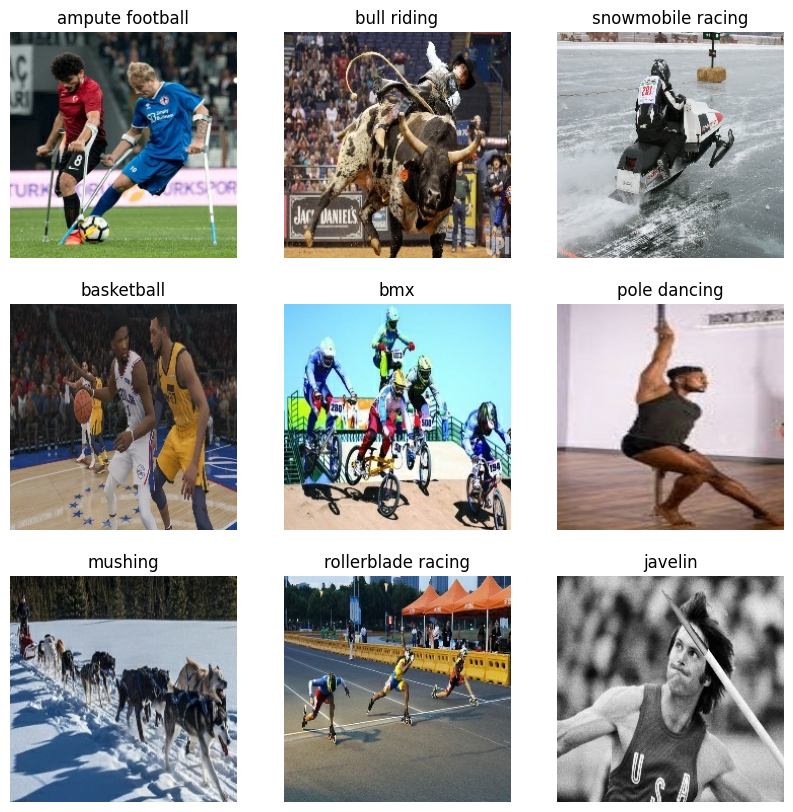

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int2label.get(int(labels[i])))
        plt.axis("off")

## Data augumentation

In [48]:
# mofidy image qualities
data_augumentation_layers = [
    layers.RandomBrightness(factor=0.3),
    layers.RandomContrast(factor=0.4),
    
]

def data_augmentation(images):
    for layer in data_augumentation_layers:
        images = layer(images)
    return images

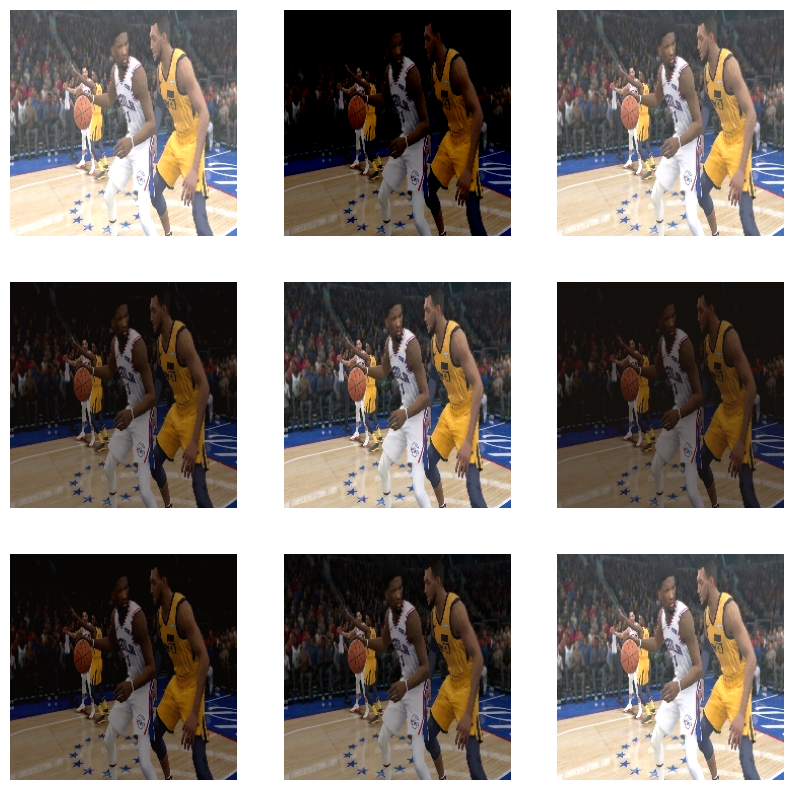

In [49]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [50]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

## Buld model

In [52]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    
    return keras.Model(inputs, outputs)

In [53]:
model = make_model(INPUT_SHAPE, NUM_CLASSES)

## Train model

In [56]:
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=val_ds,
)

Epoch 1/25


I0000 00:00:1745566612.239397      99 service.cc:148] XLA service 0x7d025c0199e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745566612.240026      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745566613.383311      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745566625.577717      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566625.886470      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566627.666418      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566627.9131

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - acc: 0.0777 - loss: 4.1037

E0000 00:00:1745566723.004591     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566723.242414     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566723.916213     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566724.178620     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745566728.333273     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

422/422 ━━━━━━━━━━━━━━━━━━━━ 140s 253ms/step - acc: 0.0779 - loss: 4.1021 - val_acc: 0.0100 - val_loss: 5.0873
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 88s 207ms/step - acc: 0.2224 - loss: 3.1156 - val_acc: 0.2200 - val_loss: 3.0241
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 88s 207ms/step - acc: 0.3338 - loss: 2.6052 - val_acc: 0.2640 - val_loss: 2.9858
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - acc: 0.4361 - loss: 2.2024 - val_acc: 0.3920 - val_loss: 2.2437
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - acc: 0.5174 - loss: 1.8468 - val_acc: 0.4400 - val_loss: 2.0522
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - acc: 0.5689 - loss: 1.6281 - val_acc: 0.4540 - val_loss: 2.1395
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - acc: 0.6285 - loss: 1.3890 - val_acc: 0.3160 - val_loss: 3.7426
Epoch 8/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - acc: 0.6860 - loss: 1.1888 - val_acc: 0.3720 - val_loss: 2.9537
Epoch 9/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 87

In [57]:
print(dir(model))

['__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_adjust_input_rank', '_allow_non_tensor_positional_args', '_api_export_path', '_api_export_symbol_id', '_assert_compile_called', '_assert_input_compatibility', '_auto_config', '_build_by_run_for_kwargs', '_build_by_run_for_single_pos_arg', '_build_shapes_dict', '_call_has_mask_arg', '_call_has_training_arg', '_call_signature', '_called', '_check_quantize_args', '_check_super_called', '_checkpoint_adapter', '_checkpoint_dependencies', '_clear_losses', '_compile_config', '_compile_loss', '_compile_metrics', '_compiled_metrics_update_state', '_

In [61]:
print(model.history.history)

{'acc': [0.12170174717903137, 0.25170472264289856, 0.3605099320411682, 0.45100799202919006, 0.528387188911438, 0.584642767906189, 0.6420841813087463, 0.693225622177124, 0.729988157749176, 0.7655647993087769, 0.8111473321914673, 0.8344945311546326, 0.8645864129066467, 0.8920841813087463, 0.9090571999549866, 0.9229913949966431, 0.9373703002929688, 0.9522680044174194, 0.9479691386222839, 0.9537503719329834, 0.9564927220344543, 0.9659057259559631, 0.9636821746826172, 0.9604209661483765, 0.9656092524528503], 'loss': [3.752561092376709, 2.983757495880127, 2.49407958984375, 2.1208529472351074, 1.7982467412948608, 1.5698539018630981, 1.3448346853256226, 1.157450556755066, 1.0100293159484863, 0.8779609799385071, 0.7253111600875854, 0.6338062286376953, 0.5320515036582947, 0.43273285031318665, 0.36831262707710266, 0.3140259087085724, 0.2678140103816986, 0.2162545919418335, 0.21533697843551636, 0.1937343031167984, 0.17573408782482147, 0.1505582183599472, 0.1507219821214676, 0.1541774719953537, 0.1

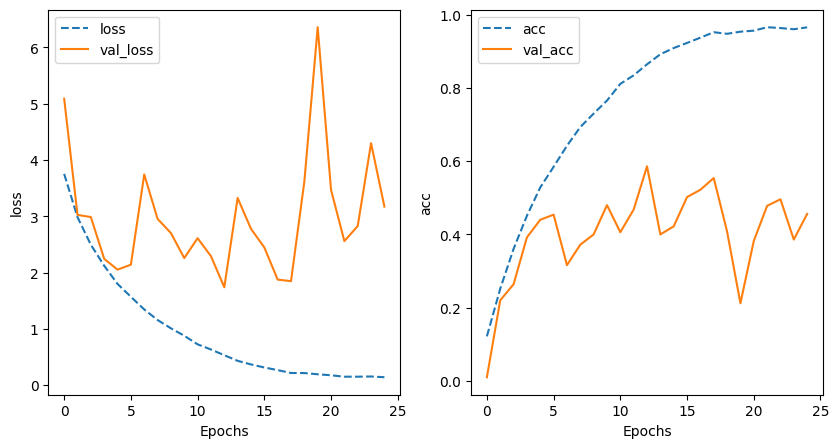

In [65]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

training_plot(['loss', 'acc'], model.history)

## Test an image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
air hockey


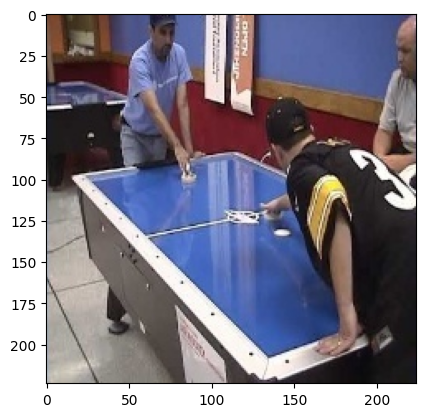

In [72]:
test_img = "/kaggle/input/sports-classification/test/air hockey/1.jpg"
img = keras.utils.load_img(test_img, target_size=IMG_SIZE)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
scores = keras.ops.softmax(predictions)
intlabel = int(keras.ops.argmax(scores, axis=-1)[0])
print(int2label[intlabel])

## Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


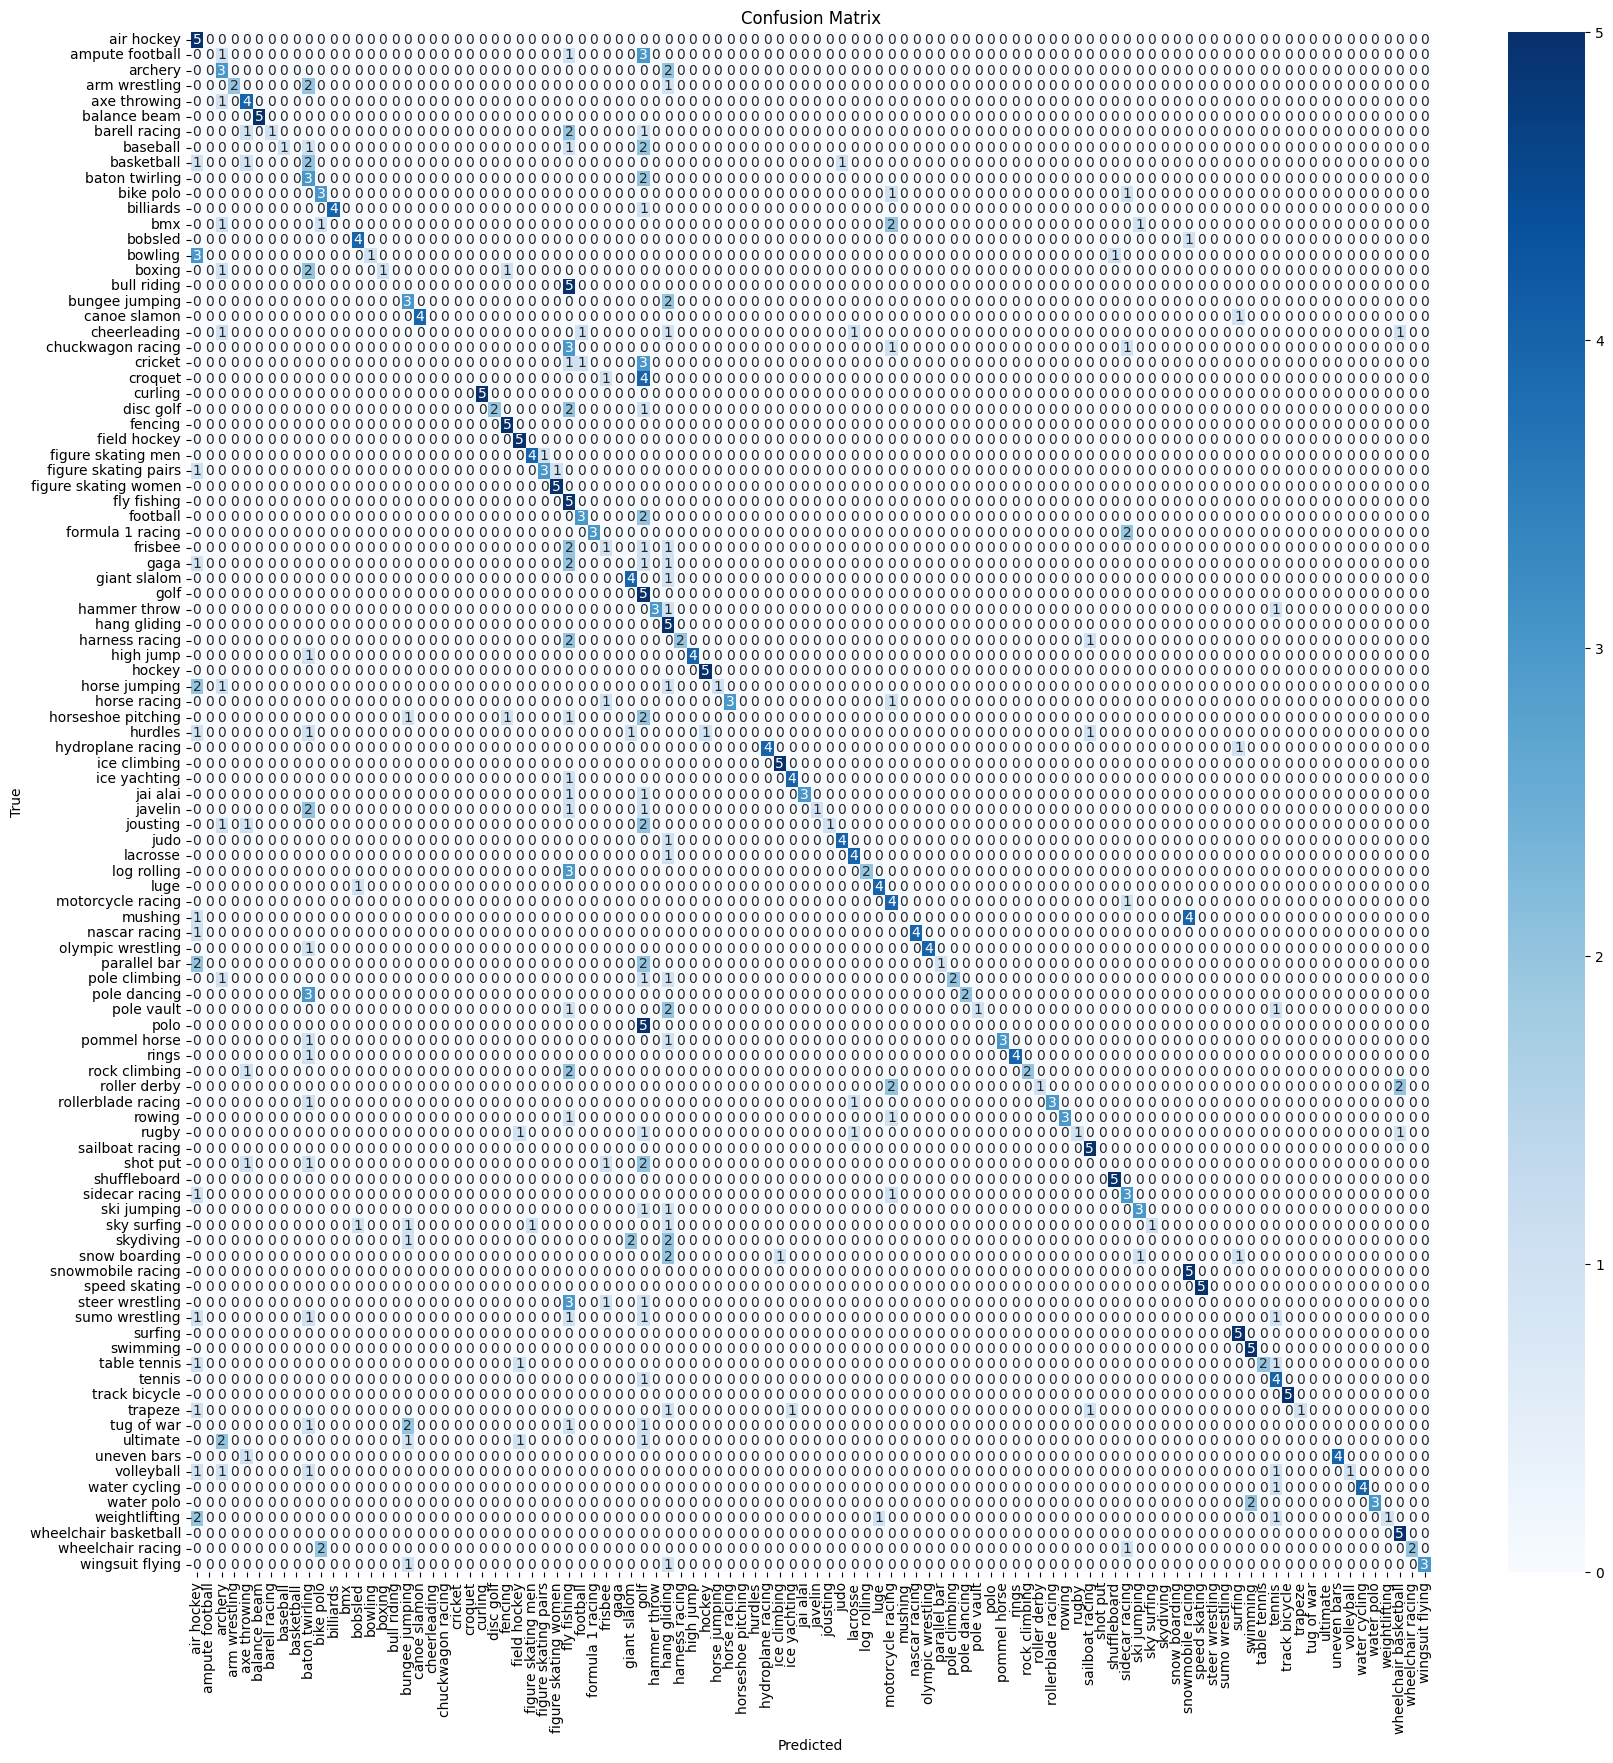

                       precision    recall  f1-score   support

           air hockey       0.20      1.00      0.33         5
      ampute football       0.00      0.00      0.00         5
              archery       0.21      0.60      0.32         5
        arm wrestling       1.00      0.40      0.57         5
         axe throwing       0.40      0.80      0.53         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      0.20      0.33         5
             baseball       1.00      0.20      0.33         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.12      0.60      0.20         5
            bike polo       0.50      0.60      0.55         5
            billiards       1.00      0.80      0.89         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.67      0.80      0.73         5
              bowling       1.00      0.20      0.33  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
# Get class names from the test dataset
class_names = test_ds.class_names

# Create lists to store true labels and predictions
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    # Get predictions
    predictions = model.predict(images)
    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Extend the lists with batch data
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))